# Modelo de aprendizaje sobre datos del SUAC - Buenos Aires Data

In [1]:
##Importamos librerias.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

## Importamos Data Set consolidado y limpiamos detalles

In [3]:
##Importamos Dataset de SUAC 2017 y 2018 concatenado.
datasuac = pd.read_csv('/Users/ezetalamona/Desktop/Ciencia de Datos/Ciencia de Datos - UTN FRBA/Trabajo final/SUAC Datasets/sistema-unico-de-atencion-ciudadana-consolidado.csv', delimiter=',', decimal=",", parse_dates = True, low_memory=False)

In [4]:
np.shape(datasuac)

(1552422, 17)

In [5]:
datasuac.head()

,Unnamed: 0,PERIODO,CATEGORIA,SUBCATEGORIA,CONCEPTO,TIPO_PRESTACION,FECHA_INGRESO,HORA_INGRESO,DOMICILIO_CGPC,DOMICILIO_BARRIO,DOMICILIO_CALLE,DOMICILIO_ALTURA,LAT,LONG,CANAL,GENERO,ESTADO_DEL_CONTACTO
0,0,201701,CALLES Y VEREDAS,REPARACION DE VEREDA,REPARACION DE VEREDA,SOLICITUD,2/1/2017,5:48:31 p.m.,COMUNA 5,BOEDO,GIBSON,4192.0,-34.638971681443,-58.4224202457747,WEB,FEMENINO,ABIERTO
1,1,201701,MEDIOS DE TRANSPORTE,BICICLETAS,INCONVENIENTES CON ECOBICIS,QUEJA,2/1/2017,1:47:51 p.m.,COMUNA 4,BOCA,"GARCIA, MARTIN AV.",364.0,-34.6289108066142,-58.3699400129738,147,MASCULINO,ABIERTO
2,2,201701,MEDIOS DE TRANSPORTE,BICICLETAS,INCONVENIENTES CON ECOBICIS,QUEJA,2/1/2017,2:08:49 p.m.,COMUNA 4,BOCA,"GARCIA, MARTIN AV.",364.0,-34.6289108066142,-58.3699400129738,147,MASCULINO,ABIERTO
3,3,201701,MEDIOS DE TRANSPORTE,BICICLETAS,INCONVENIENTES CON ECOBICIS,QUEJA,3/1/2017,4:50:42 p.m.,COMUNA 14,PALERMO,JUNCAL,3102.0,-34.5860840647047,-58.4084105506486,WEB,FEMENINO,ABIERTO
4,4,201701,LIMPIEZA Y RECOLECCIÓN,CESTOS Y CONTENEDORES,INSTALACION/REPARACION DE CONTENEDOR,SOLICITUD,3/1/2017,4:54:36 p.m.,COMUNA 4,PARQUE PATRICIOS,"GARAY, JUAN DE AV.",2158.0,-34.6275856312034,-58.3934973144262,WEB,MASCULINO,ABIERTO


In [6]:
datasuac.isnull().sum()

Unnamed: 0                  0
PERIODO                     0
CATEGORIA                   0
SUBCATEGORIA             8586
CONCEPTO                    0
TIPO_PRESTACION             0
FECHA_INGRESO               0
HORA_INGRESO                0
DOMICILIO_CGPC              0
DOMICILIO_BARRIO            0
DOMICILIO_CALLE             0
DOMICILIO_ALTURA       109747
LAT                         0
LONG                        0
CANAL                       0
GENERO                      6
ESTADO_DEL_CONTACTO         0
dtype: int64

In [7]:
##Elimino NaNs de GENERO
datasuac = datasuac.dropna(subset = ['GENERO'])

In [8]:
##Elimino todas las filas que tengan GENERO DESCONOCIDO para el análisis
datasuac = datasuac[~datasuac.GENERO.str.contains("DESCONOCIDO")]

In [9]:
## Me quedo solo con Masculino y Femenino
datasuac['GENERO'].unique()

array(['FEMENINO', 'MASCULINO'], dtype=object)

In [10]:
## Elimino columna Unnamed
datasuac = datasuac.drop(columns=['Unnamed: 0'])

In [11]:
datasuac['CATEGORIA'] = datasuac['CATEGORIA'].replace("TRAMITES Y SERVICIOS","TRÁMITES Y SERVICIOS")

In [12]:
print(type(datasuac['PERIODO']))

<class 'pandas.core.series.Series'>


## Generamos Data Frame con Dummies para comenzar con el aprendizaje del Modelo

In [13]:
suacan = datasuac.iloc[:,[1,4,7,13,14]]

In [15]:
suacan.columns

Index(['CATEGORIA', 'TIPO_PRESTACION', 'DOMICILIO_CGPC', 'CANAL', 'GENERO'], dtype='object')

In [16]:
# Dummies para la feature "CATEGORIA"
categoria_dummie = pd.get_dummies(suacan.CATEGORIA)
categoria_dummie.head(3)

,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIO AMBIENTE Y RECICLADO,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [17]:
# Dummies para la feature "TIPO_PRESTACION"
tipo_de_prestacion_dummie = pd.get_dummies(suacan.TIPO_PRESTACION)
tipo_de_prestacion_dummie.head(3)

,DENUNCIA,QUEJA,REPORTE,SERVICIO,SOLICITUD
0,0,0,0,0,1
1,0,1,0,0,0
2,0,1,0,0,0


In [18]:
# Dummies para la feature "GENERO"
genero_dummie = pd.get_dummies(suacan.GENERO)
genero_dummie.head(3)

,FEMENINO,MASCULINO
0,1,0
1,0,1
2,0,1


In [19]:
# Dummies para la feature "DOMICILIO_CGPC"
comuna_dummie = pd.get_dummies(suacan.DOMICILIO_CGPC)
comuna_dummie.head(3)

,COMUNA 1,COMUNA 10,COMUNA 11,COMUNA 12,COMUNA 13,COMUNA 14,COMUNA 15,COMUNA 2,COMUNA 3,COMUNA 4,COMUNA 5,COMUNA 6,COMUNA 7,COMUNA 8,COMUNA 9
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [20]:
## Utilizo un JOIN para unir las dummies a mi tabla inicial
suacan = suacan.join([categoria_dummie, tipo_de_prestacion_dummie, genero_dummie, comuna_dummie])
suacan.head(10)

,CATEGORIA,TIPO_PRESTACION,DOMICILIO_CGPC,CANAL,GENERO,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",...,COMUNA 14,COMUNA 15,COMUNA 2,COMUNA 3,COMUNA 4,COMUNA 5,COMUNA 6,COMUNA 7,COMUNA 8,COMUNA 9
0,CALLES Y VEREDAS,SOLICITUD,COMUNA 5,WEB,FEMENINO,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 14,WEB,FEMENINO,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,LIMPIEZA Y RECOLECCIÓN,SOLICITUD,COMUNA 4,WEB,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,TRÁNSITO,DENUNCIA,COMUNA 10,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,TRÁNSITO,DENUNCIA,COMUNA 13,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,TRÁNSITO,DENUNCIA,COMUNA 15,WEB,MASCULINO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,TRÁNSITO,DENUNCIA,COMUNA 13,WEB,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,TRÁNSITO,DENUNCIA,COMUNA 13,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
## Guardo variable para posterior Test
suacanprueba = suacan

In [22]:
## Filtro mi Data para poder correr el modelo en tiempos lógicos
suacan = suacan.loc[datasuac['FECHA_INGRESO'].str.contains("1/2017")]

In [23]:
suacany = suacan.iloc[:,[3]]

In [24]:
suacany.head()

,CANAL
0,WEB
1,147
2,147
3,WEB
4,WEB


In [25]:
## Elimino columnas categoricas que no me sirven para entrenar el modelo
suacan = suacan.drop(['CATEGORIA', 'TIPO_PRESTACION', 'DOMICILIO_CGPC','GENERO','CANAL'], axis=1)

In [26]:
np.shape(suacan)

(120398, 40)

In [27]:
suacan.columns

Index(['ALUMBRADO', 'ARBOLADO Y ESPACIOS VERDES', 'CALLES Y VEREDAS',
       'CEMENTERIOS', 'CONTROL EDILICIO, OBRAS Y CATASTRO',
       'FISCALIZACIÓN ACTIVIDADES COMERCIALES', 'LIMPIEZA Y RECOLECCIÓN',
       'MEDIO AMBIENTE Y RECICLADO', 'MEDIOS DE TRANSPORTE',
       'ORDENAMIENTO DEL ESPACIO PÚBLICO', 'OTRAS', 'PLUVIALES',
       'RECICLADO Y PROTECCIÓN AMBIENTAL', 'SALUD Y SERVICIOS SOCIALES',
       'SEGURIDAD', 'SUGERENCIAS Y LIBRO DE QUEJAS', 'TRÁMITES Y SERVICIOS',
       'TRÁNSITO', 'DENUNCIA', 'QUEJA', 'REPORTE', 'SERVICIO', 'SOLICITUD',
       'FEMENINO', 'MASCULINO', 'COMUNA 1', 'COMUNA 10', 'COMUNA 11',
       'COMUNA 12', 'COMUNA 13', 'COMUNA 14', 'COMUNA 15', 'COMUNA 2',
       'COMUNA 3', 'COMUNA 4', 'COMUNA 5', 'COMUNA 6', 'COMUNA 7', 'COMUNA 8',
       'COMUNA 9'],
      dtype='object')

In [28]:
suacan.head()

,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIO AMBIENTE Y RECICLADO,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,...,COMUNA 14,COMUNA 15,COMUNA 2,COMUNA 3,COMUNA 4,COMUNA 5,COMUNA 6,COMUNA 7,COMUNA 8,COMUNA 9
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Separamos Y (CANAL) & X (Columnas anteriormente seleccionadas)

In [29]:
#Variable dependiente - Etiqueta
y = np.array(suacany[["CANAL"]])

In [96]:
# Transformamos el label del target en formato numerico para poder procesarlo 
from sklearn import preprocessing

# LabelEncoder sirve para normalizar las labels entre 0 y n-clases y ademas transforma a numerico. 
# 1 - Primero creo un objeto (con determinados argumentos) que llama a la funcion que deseo
le = preprocessing.LabelEncoder()

# 2 - AL objeto le aplico la funcion fit a los datos desados 
y = le.fit_transform(y)

# 3 - Agrego columna al Data Set originl
suacany['EncodedCanal'] = y

In [108]:
suacany.head(5)

,CANAL,EncodedCanal
0,WEB,3
1,147,0
2,147,0
3,WEB,3
4,WEB,3


In [31]:
X = suacan

In [32]:
# Separamos Train y Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=4)

In [33]:
# Auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(x_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
x_train_scaled = scaler.transform(x_train)  
print(x_train_scaled.mean(axis=0))
print(x_train_scaled.std(axis=0))

[-7.08240953e-18 -6.49220873e-17  2.59688349e-17  1.00334135e-17
  7.55457016e-17  2.24276302e-17 -8.17428100e-17 -5.01670675e-18
  2.41982325e-17 -1.29844175e-17 -1.77060238e-17  2.24276302e-17
 -2.71492365e-17  4.51503607e-17  6.49220873e-18  5.72494770e-17
 -4.01336540e-17 -8.20379104e-17  6.25612842e-17  7.08240953e-17
  2.65590357e-17  1.59354214e-17 -1.18040159e-18  1.14498954e-16
 -6.78730913e-17 -3.54120476e-18 -3.82155014e-17 -5.48886738e-17
 -8.73497175e-17  4.33797584e-17  3.40840958e-17  4.13140556e-18
  2.83296381e-17 -5.66592762e-17 -2.30178310e-17 -4.13140556e-17
 -1.68207226e-17  5.90200794e-19 -4.95768667e-17 -4.26420074e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
x_test_scaled = scaler.transform(x_test)  
print(x_test_scaled.mean(axis=0))
print(x_test_scaled.std(axis=0))

[ 0.00025477 -0.00208431  0.00148974 -0.00467866 -0.00988686  0.0010602
 -0.00281506  0.00253053 -0.00716189 -0.00149778  0.00573809  0.01782332
  0.01225887 -0.00659569 -0.00258197  0.00270514 -0.00287885  0.00559277
  0.00343003  0.00011763 -0.0049649   0.01377071 -0.01517466  0.01629853
 -0.01629853 -0.00119412  0.00736905  0.0136641   0.00212252  0.01147903
  0.00855994 -0.02686276 -0.01623991 -0.00673358  0.00591309  0.00386018
  0.00346858 -0.01235565  0.00123917 -0.00080399]
[1.00047479 0.99671692 1.00233411 0.83887051 0.97134024 1.00345436
 0.99951313 1.06712336 0.98250532 0.993022   1.09981696 1.1067596
 1.05449125 0.93802047 0.98102007 1.01097462 0.98994677 1.00398289
 1.00196966 1.00025834 0.96810824 1.00590876 0.99674827 0.9996112
 0.9996112  0.99785531 1.01171102 1.01912585 1.00300338 1.01518535
 1.01398575 0.95790271 0.959074   0.98579571 1.01049038 1.00788523
 1.00685339 0.97844615 1.0027379  0.99848826]


## Defino modelo KNN

In [36]:
# defino modelo KNN llamado "neigh"
neigh = KNeighborsClassifier(n_neighbors=2, weights = "distance")

In [37]:
parameters_k = np.arange(20,50,2)
parameters_k

array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48])

In [38]:
parameters_knn = [{'n_neighbors': parameters_k}]

In [39]:
n_folds = 5

In [40]:
classifier_neigh = GridSearchCV(neigh, parameters_knn, refit = True, cv=n_folds)

In [41]:
classifier_neigh.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
np.shape(x_test_scaled)

(108359, 40)

In [43]:
# Prediction
y_pred = classifier_neigh.predict(x_test_scaled)
print(y_pred)

[0 0 0 ... 0 0 0]


In [44]:
# Model prediciton
print(classifier_neigh.score(x_test_scaled,y_test.ravel()))

0.7749794664033445


In [93]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(y_test, y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.7749794664033445


In [94]:
# Compute confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[61298,  1615,    18,  2089],
       [ 2768, 18346,     4,   402],
       [ 1869,    15,     1,   101],
       [14288,  1207,     7,  4331]])

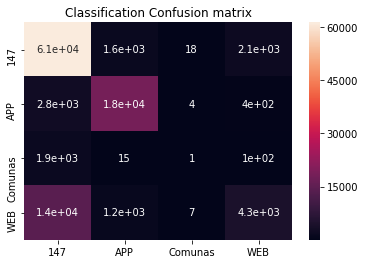

In [103]:
df_cm = pd.DataFrame(cm, index = ['147', 'APP', 'Comunas', 'WEB'], columns = ['147', 'APP', 'Comunas', 'WEB'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

In [67]:
#compute and plot AUC
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr1, tpr1)
print("El AUC es = " + str(auc))

El AUC es = 0.8498243448511369


In [46]:
np.shape(x_train_scaled)

(12039, 40)

## Pruebo Modelo con otro mes -> Enero 2018

### Primero creamos nuevamente un Data Frame con Dummies para Enero 2018 (Similar a los pasos de creación de la primer tabla de Dummies)

In [74]:
suacanprueba = datasuac.iloc[:,[1,4,7,13,14]]

In [75]:
suacanprueba.head()

,CATEGORIA,TIPO_PRESTACION,DOMICILIO_CGPC,CANAL,GENERO
0,CALLES Y VEREDAS,SOLICITUD,COMUNA 5,WEB,FEMENINO
1,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO
2,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO
3,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 14,WEB,FEMENINO
4,LIMPIEZA Y RECOLECCIÓN,SOLICITUD,COMUNA 4,WEB,MASCULINO


In [76]:
# Dummies para la feature "CATEGORIA"
categoria_dummie = pd.get_dummies(suacanprueba.CATEGORIA)
genero_dummie = pd.get_dummies(suacanprueba.GENERO)
comuna_dummie = pd.get_dummies(suacanprueba.DOMICILIO_CGPC)
tipo_de_prestacion_dummie = pd.get_dummies(suacanprueba.TIPO_PRESTACION)

In [77]:
suacanprueba = suacanprueba.join([categoria_dummie, tipo_de_prestacion_dummie, genero_dummie, comuna_dummie])
suacanprueba.head(10)

,CATEGORIA,TIPO_PRESTACION,DOMICILIO_CGPC,CANAL,GENERO,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",...,COMUNA 14,COMUNA 15,COMUNA 2,COMUNA 3,COMUNA 4,COMUNA 5,COMUNA 6,COMUNA 7,COMUNA 8,COMUNA 9
0,CALLES Y VEREDAS,SOLICITUD,COMUNA 5,WEB,FEMENINO,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 4,147,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,MEDIOS DE TRANSPORTE,QUEJA,COMUNA 14,WEB,FEMENINO,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,LIMPIEZA Y RECOLECCIÓN,SOLICITUD,COMUNA 4,WEB,MASCULINO,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,TRÁNSITO,DENUNCIA,COMUNA 10,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,TRÁNSITO,DENUNCIA,COMUNA 13,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,TRÁNSITO,DENUNCIA,COMUNA 15,WEB,MASCULINO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,TRÁNSITO,DENUNCIA,COMUNA 13,WEB,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,TRÁNSITO,DENUNCIA,COMUNA 13,APP,MASCULINO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
suacanprueba = suacanprueba.loc[datasuac['FECHA_INGRESO'].str.contains("2018-02")]

In [79]:
suacanpruebay = suacanprueba.iloc[:,[3]]

In [80]:
suacanprueba = suacanprueba.drop(['CATEGORIA', 'TIPO_PRESTACION', 'DOMICILIO_CGPC','GENERO','CANAL'], axis=1)

In [81]:
suacanprueba.columns

Index(['ALUMBRADO', 'ARBOLADO Y ESPACIOS VERDES', 'CALLES Y VEREDAS',
       'CEMENTERIOS', 'CONTROL EDILICIO, OBRAS Y CATASTRO',
       'FISCALIZACIÓN ACTIVIDADES COMERCIALES', 'LIMPIEZA Y RECOLECCIÓN',
       'MEDIO AMBIENTE Y RECICLADO', 'MEDIOS DE TRANSPORTE',
       'ORDENAMIENTO DEL ESPACIO PÚBLICO', 'OTRAS', 'PLUVIALES',
       'RECICLADO Y PROTECCIÓN AMBIENTAL', 'SALUD Y SERVICIOS SOCIALES',
       'SEGURIDAD', 'SUGERENCIAS Y LIBRO DE QUEJAS', 'TRÁMITES Y SERVICIOS',
       'TRÁNSITO', 'DENUNCIA', 'QUEJA', 'REPORTE', 'SERVICIO', 'SOLICITUD',
       'FEMENINO', 'MASCULINO', 'COMUNA 1', 'COMUNA 10', 'COMUNA 11',
       'COMUNA 12', 'COMUNA 13', 'COMUNA 14', 'COMUNA 15', 'COMUNA 2',
       'COMUNA 3', 'COMUNA 4', 'COMUNA 5', 'COMUNA 6', 'COMUNA 7', 'COMUNA 8',
       'COMUNA 9'],
      dtype='object')

In [82]:
np.shape(suacanprueba)

(97903, 40)

## Ajusto modelo al nuevo Train Set de Enero 2018

In [83]:
# Auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(x_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [84]:
#Variable dependiente - Etiqueta
yenero18 = np.array(suacanpruebay[["CANAL"]])

In [85]:
# Transformamos el label del target en formato numerico para poder procesarlo 
from sklearn import preprocessing

# LabelEncoder sirve para normalizar las labels entre 0 y n-clases y ademas transforma a numerico. 
# 1 - Primero creo un objeto (con determinados argumentos) que llama a la funcion que deseo
le = preprocessing.LabelEncoder()

# 2 - AL objeto le aplico la funcion fit a los datos desados 
yenero18 = le.fit_transform(yenero18)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
x_test_enero18 = suacanprueba

In [87]:
x_test_enero18 = suacanprueba.head(108359)

In [88]:
np.shape(x_test_enero18)

(97903, 40)

In [89]:
x_test_scaled_enero18 = scaler.transform(x_test_enero18)  
print(x_test_scaled.mean(axis=0))
print(x_test_scaled.std(axis=0))

[ 0.00025477 -0.00208431  0.00148974 -0.00467866 -0.00988686  0.0010602
 -0.00281506  0.00253053 -0.00716189 -0.00149778  0.00573809  0.01782332
  0.01225887 -0.00659569 -0.00258197  0.00270514 -0.00287885  0.00559277
  0.00343003  0.00011763 -0.0049649   0.01377071 -0.01517466  0.01629853
 -0.01629853 -0.00119412  0.00736905  0.0136641   0.00212252  0.01147903
  0.00855994 -0.02686276 -0.01623991 -0.00673358  0.00591309  0.00386018
  0.00346858 -0.01235565  0.00123917 -0.00080399]
[1.00047479 0.99671692 1.00233411 0.83887051 0.97134024 1.00345436
 0.99951313 1.06712336 0.98250532 0.993022   1.09981696 1.1067596
 1.05449125 0.93802047 0.98102007 1.01097462 0.98994677 1.00398289
 1.00196966 1.00025834 0.96810824 1.00590876 0.99674827 0.9996112
 0.9996112  0.99785531 1.01171102 1.01912585 1.00300338 1.01518535
 1.01398575 0.95790271 0.959074   0.98579571 1.01049038 1.00788523
 1.00685339 0.97844615 1.0027379  0.99848826]


In [90]:
# Prediction prueba con Enero 2018
y_predenero18 = classifier_neigh.predict(x_test_scaled_enero18)
print(y_predenero18)

[3 3 3 ... 3 1 3]


In [91]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(yenero18, y_predenero18)
print("El accuracy es " + str(test_acc))

El accuracy es 0.8716280399987743


In [104]:
# Compute confusion Matrix
cm = confusion_matrix(yenero18, y_predenero18)
cm

array([[28270,   725,     9,  1981],
       [ 1466, 11669,     2,   202],
       [  739,     5,     3,    54],
       [ 6917,   468,     0, 45393]])

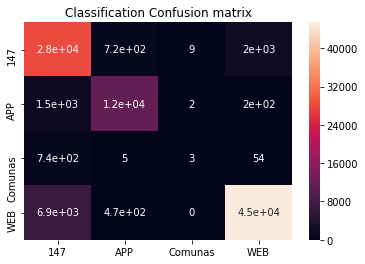

In [105]:
df_cm = pd.DataFrame(cm, index = ['147', 'APP', 'Comunas', 'WEB'], columns = ['147', 'APP', 'Comunas', 'WEB'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

In [66]:
## Best group ever (???